# Could we create a classifier that can distinguish between two music genres using Spotify API data?

## 1. Overview

In addition to the basic song metadata like release date, duration and genre, the Spotify API can bring some information about the audio of the tracks. The "Audio Features"  are metrics created by Spotify's audio analyzer softwares and relates to music theory stuff (like tempo, key and mode) and with how people perceive the song (like its energy, danceability and valence). 

The objective of this project is, at first, to create a classifier that can distinguish tracks between brazilian rap and indie genres based on the Audio Features available in Spotify API.

Even if its easy to an human to classify correctly music genres, the large quantity of songs that are released every day makes it difficult and expensive to have people listening to and classifying them. Recomendation, for example, is one of the features that attracts people to use streaming apps like Spotify, so using audio features extracted by audio analysis softwares to help this process can be one of the decisive points of the success of a streaming service.

## 2. ETL

Using the Spotify API is made easier by the **_spotipy_** library. This library makes it easy to authenticate and access the API endpoints without needing to write every request.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [2]:
cid = ''
secret = ''

In [3]:
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) # Creating the credentials manager
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

Data extraction will follow this process:

1. A list of artist names should be provided, along with their music genres
2. The API will find the artist ID to access the albums and track information (sp.search())
3. All artist albums will be found (sp.artist_albums())
4. For each album, all track data will be extracted (sp.album_tracks())
5. In addition to Audio Features (sp.audio_features()), album name (sp.artist_albums()), artist name (sp.artist()), track name and release date (sp.track()), the genre provided in step 1 and track id will be stored in the data
6. The user will have some control over how many albums that will be extracted, terms that would cause an album to be ignored if they are in its name (like "Live", "Instrumental" or "Acapella") and some features to prevent the extraction of misleading data.

The following function (artist_tracks()) makes it easy to repeat this process for a big number of artists:

In [4]:
def artist_tracks(sp,df,artist_name,genre=np.nan,exclude=[],quantity=np.inf,max_no_album=np.inf):
    artist_id = 'spotify:artist:' + sp.search(q='artist:' + artist_name, type='artist')['artists']['items'][0]['id'] 
    # Find the id of the first artist that appears on the search
    tracks = []
    artist = sp.artist(artist_id) # Get the artist data
    artist_albums = sp.artist_albums(artist_id)['items'] # Get the artist album data
    c = 0
    if quantity == 0: # Just to ease the process of checking if the search result is correct
        return df
    for album in artist_albums: # Iterate through the found albums
        if album['total_tracks'] > 8 and album['total_tracks'] < max_no_album and not any(True for item in exclude if item in album['name']):
            # Condition to considerate a album as valid to extract
            c+=1 # Extracted albums counter
            album_tracks = sp.album_tracks(album['id'])['items'] # Get album tracks
            for track in album_tracks: # Iterate through album tracks
                track_data = sp.audio_features(track['id'])[0]  # Get track audio features
                track_data['artist'] = artist['name'] # Stores data from the artist, track and album
                track_data['name'] = track['name']
                track_data['album'] = album['name']
                track_data['release'] = album['release_date']
                track_data['genre'] = genre
                tracks.append(track_data) # Add track data to the dict list
        if c >= quantity: # Check if the max quantity of albums was reached
            break
    tracks_df = pd.DataFrame(tracks) # Create a dataframe with the track data
    tracks_df = tracks_df.set_index('id') # Turn the track id into the index of the dataframe
    if len(df) == 0: # If the tracks df is empty, return the created dataframe
        return tracks_df
    else: # If not, append the new dataframe to it
        return df.append(tracks_df)

For indie, we will extract tracks from **Boogarins, Carne Doce, Jovem Dionísio, Maglore, Tagua Tagua, Letrux, O Terno, Terno Rei, Ana Frango Elétrico, Bala Desejo, Liniker, Time Bernardes, Giovani Cidreira e Rubel.**

For rap, we will extract tracks from **Djonga, Marcelo D2, Facção Central, Emicida, FBC, Coruja BC1, Major RD, 509-e, Criolo e Dalsin.**

In [5]:
indie_list = ['boogarins','carne doce','jovem dionísio','maglore','tagua tagua','letrux','o terno','terno rei','ana frango elétrico','bala desejo', 'liniker', 'tim bernardes', 'giovani cidreira', 'Rubel']
rap_list = ['djonga','marcelo d2','racionais','facção central','emicida','FBC','Coruja BC1','Major RD','509-e','criolo','dalsin']

In [6]:
df = pd.DataFrame()
for artist_name in indie_list:
    df = artist_tracks(sp,df,artist_name,genre='indie',exclude=['Live','Ao Vivo','Instrumental'],quantity=4,max_no_album=20)
for artist_name in rap_list:
    df = artist_tracks(sp,df,artist_name,genre='rap',exclude=['Live','Ao Vivo','Instrumental'],quantity=4,max_no_album=20)

The extracted data will be saved in the file "spotify_data.csv".

In [7]:
df.to_csv('spotify_data.csv')

In [8]:
df['genre'].value_counts()

rap      530
indie    528
Name: genre, dtype: int64

## 3. EDA

To help understand the extracted data, I will quote [Spotify API description of Audio Features](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features).

### 3.0 Data integrity

First, we are going to use the df.isnull().sum() function to check if there are any missing values.

In [9]:
df.isnull().sum()

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
type                0
uri                 0
track_href          0
analysis_url        0
duration_ms         0
time_signature      0
artist              0
name                0
album               0
release             0
genre               0
dtype: int64

With df.info() we will check if the data types are correctly assigned.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1058 entries, 5zwvCa9LuVB46IQwKODSW3 to 15p4suAGKJyfCaocKZM7Im
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      1058 non-null   float64
 1   energy            1058 non-null   float64
 2   key               1058 non-null   int64  
 3   loudness          1058 non-null   float64
 4   mode              1058 non-null   int64  
 5   speechiness       1058 non-null   float64
 6   acousticness      1058 non-null   float64
 7   instrumentalness  1058 non-null   float64
 8   liveness          1058 non-null   float64
 9   valence           1058 non-null   float64
 10  tempo             1058 non-null   float64
 11  type              1058 non-null   object 
 12  uri               1058 non-null   object 
 13  track_href        1058 non-null   object 
 14  analysis_url      1058 non-null   object 
 15  duration_ms       1058 non-null   int64  
 16  time_sig

### 3.1 Univariate Analysis

To help with the analysis, a _**target**_ boolean feature will be created, which is True for rap and False for indie.

In [11]:
df['target'] = df['genre'].map({'rap': True,'indie': False})

Some plot functions were created to standardize the univariate plots.

In [12]:
def count_1d(df,x,hue):
    sns.countplot(x=x,data=df,hue=hue,alpha=0.5)

def describe_1d(df,x,hue,discrete=False):
    print_df = pd.DataFrame()
    if discrete:
        for label in df[hue].unique():
            label_df = pd.DataFrame(df.loc[df[hue] == label][x].value_counts())
            label_df.columns = [label]
            label_df = label_df/len(df.loc[df[hue] == label])
            print_df = print_df.append(label_df.transpose())
        cols = sorted(print_df.columns)
        print_df = print_df[cols]
        
    else:
        for label in df[hue].unique():
            label_df = pd.DataFrame(df.loc[df[hue] == label].describe()[x])
            label_df.columns = [label]
            print_df = print_df.append(label_df.transpose())
    display(print_df)
    
def kde_1d(df,x,hue):
    fig, axes = plt.subplots(1,2,figsize=(10,6))
    sns.kdeplot(ax=axes[0],x=x,data=df,hue=hue,fill=True,thresh=0,cut=0)
    sns.boxplot(ax=axes[1],x=hue,y=x,data=df)

#### 3.1.0 Genre

First, we are going to check the balance of the dataset.

In [13]:
df['genre'].value_counts()

rap      530
indie    528
Name: genre, dtype: int64

The dataset is almost perfectly balanced, so we can go on.

#### 3.1.1 Acousticness

> - **acousticness (float)**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. >= 0<= 1

The "Acousticness" feature measures, in some way, the probability that the track is acoustic.

Rap tracks tend to have electronically produced beats, but acoustic rap is also a fairly common subgenre.

Indie tracks tend to have more acoustic instruments like guitars and drums, but some of them are similar to rock songs, using electric guitars and synths.

,count,mean,std,min,25%,50%,75%,max
indie,528.0,0.422714,0.309704,0.000032,0.13650,0.4025,0.70600,0.994
rap,530.0,0.337066,0.261645,0.000315,0.10925,0.2775,0.54775,0.954


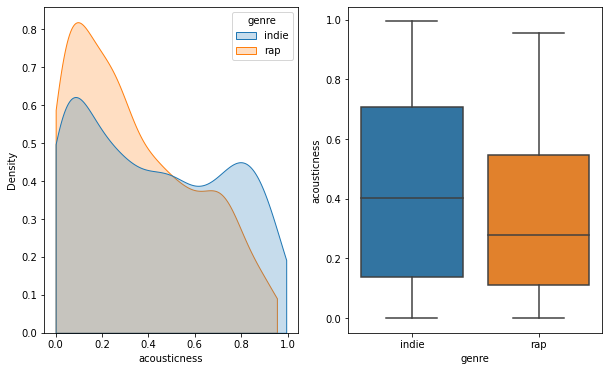

In [14]:
describe_1d(df,'acousticness','genre')
kde_1d(df,'acousticness','genre')

Indie seems to have two peaks in acousticness distribution, having a higher proportion of tracks with low acousticness.
Most rap tracks have low acousticness (< 0.3), but some of them have high acousticness rate.

#### 3.1.2 Danceablity

> - **danceability (float)**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

Rap songs tend to have strong beats that dictate the rhythm of the song, while in indie the "hand played" instruments and the fact the lyrics are more "sung" and not speech make it easy to the song to have different "phases", being more irregular and unstable.

,count,mean,std,min,25%,50%,75%,max
indie,528.0,0.551562,0.151369,0.0856,0.43350,0.5585,0.66825,0.883
rap,530.0,0.703149,0.123904,0.2500,0.62825,0.7200,0.78500,0.954


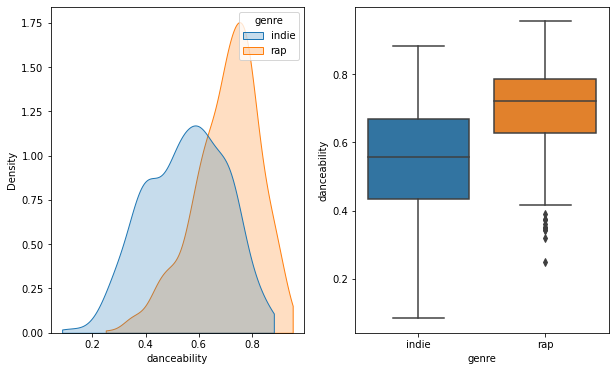

In [15]:
describe_1d(df,'danceability','genre')
kde_1d(df,'danceability','genre')

Rap songs have higher average danceability (0.7 versus 0.55) and less variance than indie songs. 

#### 3.1.3 Duration

> - **duration_ms (integer)**: The duration of the track in milliseconds.

It's not expected that the songs duration are different between the genres. Some may say that today songs tend to be shorter because of the need to have impact on the social media, but this may affect both genres in a similar way.

,count,mean,std,min,25%,50%,75%,max
indie,528.0,224953.310606,84398.873553,24813.0,177517.0,223572.0,266026.00,822888.0
rap,530.0,229173.915094,97832.626560,17706.0,171000.0,216970.0,273518.75,680880.0


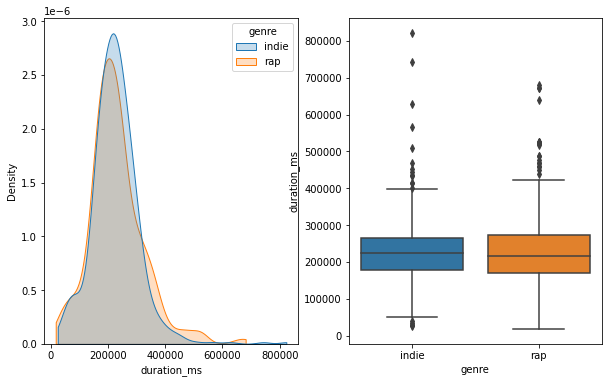

In [16]:
describe_1d(df,'duration_ms','genre')
kde_1d(df,'duration_ms','genre')

Both distributions are pretty similar.

#### 3.1.4 Energy

> - **energy (float)**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

Rap songs are expected to feel faster, louder and noisier than indie songs. The use of electronic beats that tend to be more aggressive on subgenres like **Boom-Bap** and **Trap** can be correlated with higher energy. Indie songs tend to be calm and have a low energy rate, principally if we look at the songs that can be understood as **Nova MPB** songs, but if we look at songs that are next to **Rock** the energy should be bigger.

,count,mean,std,min,25%,50%,75%,max
indie,528.0,0.483650,0.205865,0.0199,0.3345,0.491,0.64025,0.923
rap,530.0,0.629849,0.165845,0.0381,0.5360,0.652,0.74900,0.949


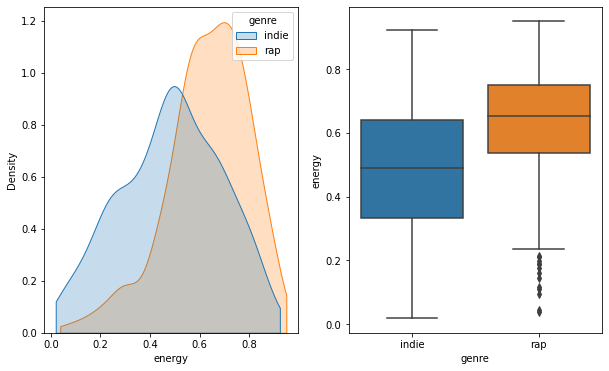

In [17]:
describe_1d(df,'energy','genre')
kde_1d(df,'energy','genre')

Indie has an average energy of 0.48, having a wide distribution, while rap hax an average of 0.63, with the biggest part of the songs having an energy rate higher than 0.4.

#### 3.1.5 Instrumentalness

> - **instrumentalness (float)**: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

The dataset is not expected to have many instrumental songs. A word filter was applied in the extraction, but some of these can be on the dataset. Even if they are not instrumental songs, indie tracks tend to have a bigger instrumentalness than rap songs, because of the lack of spoken words and the higher presence of instruments.

,count,mean,std,min,25%,50%,75%,max
indie,528.0,0.113236,0.224517,0.0,0.000038,0.00294,0.082700,0.972
rap,530.0,0.025618,0.135098,0.0,0.000000,0.00000,0.000011,0.925


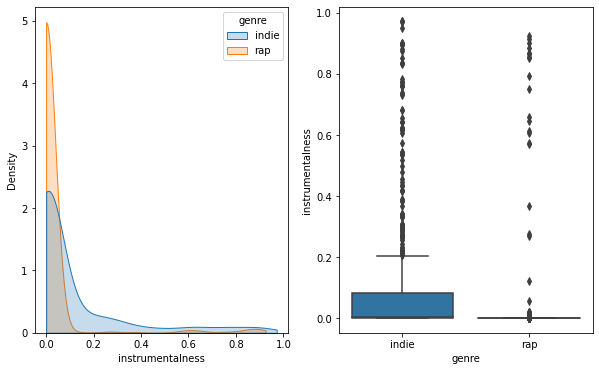

In [18]:
describe_1d(df,'instrumentalness','genre')
kde_1d(df,'instrumentalness','genre')

#### 3.1.6 Key

> - **key (integer)**: The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1. >= -1<= 11



,0,1,2,3,4,5,6,7,8,9,10,11
indie,0.109848,0.075758,0.126894,0.017045,0.098485,0.066288,0.089015,0.089015,0.064394,0.125000,0.035985,0.102273
rap,0.103774,0.149057,0.084906,0.026415,0.058491,0.064151,0.103774,0.071698,0.090566,0.069811,0.077358,0.100000


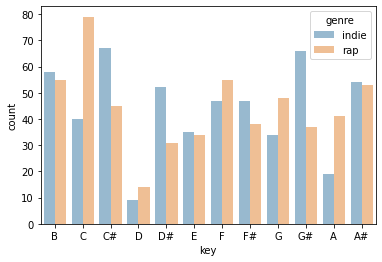

In [19]:
describe_1d(df,'key','genre',discrete=True)
fig, ax = plt.subplots()
count_1d(df,'key','genre')
_ = ax.set_xticks(ticks = list(range(12)),labels=['B','C','C#','D','D#','E','F','F#','G','G#','A','A#'])

#### 3.1.7 Liveness

> - **liveness (float)**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

As with the instrumentalness, live records were (theoretically) filtered at the extraction process.

,count,mean,std,min,25%,50%,75%,max
indie,528.0,0.182961,0.149517,0.0225,0.1010,0.121,0.20425,0.958
rap,530.0,0.223444,0.188839,0.0239,0.0987,0.140,0.29775,0.985


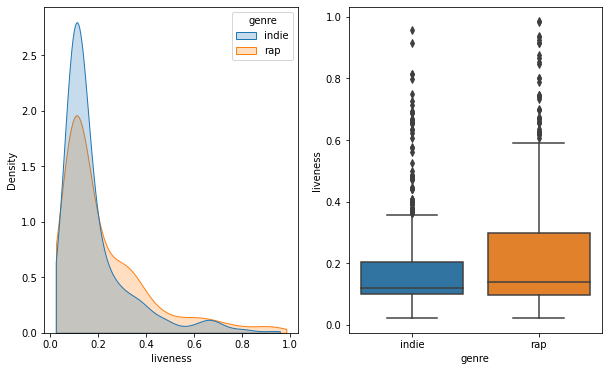

In [20]:
describe_1d(df,'liveness','genre')
kde_1d(df,'liveness','genre')

The distributions are pretty similar.

#### 3.1.8 Loudness

> - **loudness (float)**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.

Indie songs, as said in 3.1.2 section, tend to be more unstable and have different phases, some loud and some quiet. So, because of this, indie songs may have a smaller average loudness than rap songs.

,count,mean,std,min,25%,50%,75%,max
indie,528.0,-10.066335,3.589778,-28.732,-11.866,-9.6535,-7.6735,-3.296
rap,530.0,-8.120760,3.514581,-29.899,-9.171,-7.2180,-6.0320,-2.126


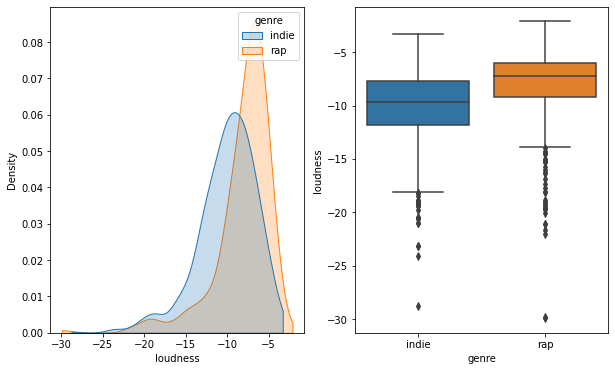

In [21]:
describe_1d(df,'loudness','genre')
kde_1d(df,'loudness','genre')

Rap songs have a slightly higher loudness than indie (-8.1 vs. -10 dB). Also, rap loudness distribution seems to have a higher skewness than indie.

#### 3.1.9 Mode

> - **mode (integer)**: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

,0,1
indie,0.393939,0.606061
rap,0.484906,0.515094


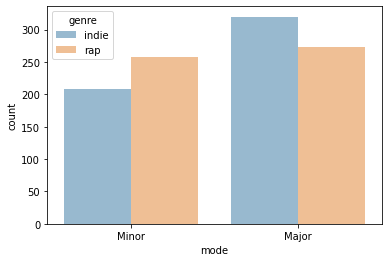

In [22]:
describe_1d(df,'mode','genre',discrete = True)
fig, ax = plt.subplots()
count_1d(df,'mode','genre')
_ = ax.set_xticks(ticks = [0,1],labels=['Minor','Major'])

Rap songs are more evenly distributed between major and minor modes than indie songs, that are 60% major.

#### 3.1.10 Speechiness

> - **speechiness (float)**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

As the Spotify API documentation description states, rap songs typically have a higher speechiness than other genres. This comes from the fact that rap lyrics are more spoken than sung in some cases.

,count,mean,std,min,25%,50%,75%,max
indie,528.0,0.075722,0.112883,0.0246,0.0330,0.04085,0.0571,0.936
rap,530.0,0.289143,0.185601,0.0337,0.1515,0.28300,0.3700,0.952


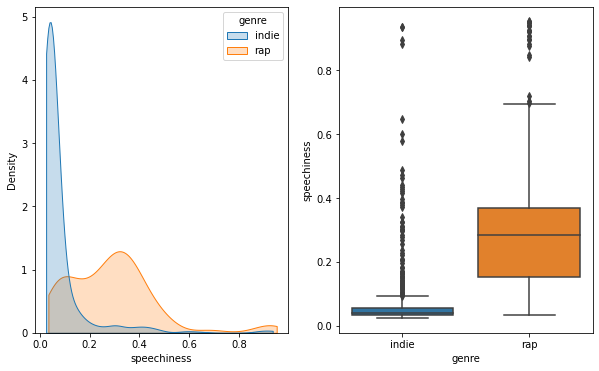

In [23]:
describe_1d(df,'speechiness','genre')
kde_1d(df,'speechiness','genre')

The distributions are very different. While indie songs have a low speechiness rate, with more than 75% of them being less than 0.06, rap songs have a mean speechiness of 0.29. This feature has great potential to make it possible to classify the genres correctly.

#### 3.1.11 Tempo

> - **tempo (float)**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

,count,mean,std,min,25%,50%,75%,max
indie,528.0,117.469134,25.637072,56.943,99.98775,116.8015,131.10225,206.494
rap,530.0,116.205532,31.821497,59.105,87.15750,112.3020,142.63300,200.232


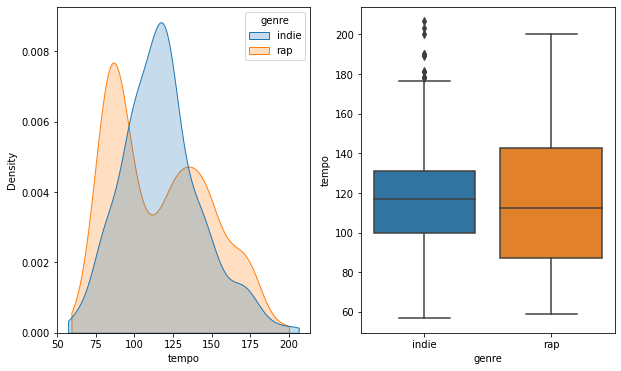

In [43]:
describe_1d(df,'tempo','genre')
kde_1d(df,'tempo','genre')

Rap tracks have two peaks of tempo distribution: one around 85-90 and another around 140, which can be related with **Boom-Bap** and **Trap** songs, respectively. Indie tracks, on the other hand, have a tempo distribution with an average similar to rap (117) and a standard deviation of 25.6, showing a certain similarity with a normal distribution.

#### 3.1.12 Time Signature

> - **time_signature (integer)**: An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4". >= 3<= 7

Most songs have a 4/4 time signature.

,1,3,4,5
indie,0.017045,0.126894,0.846591,0.009470
rap,0.011321,0.041509,0.905660,0.041509


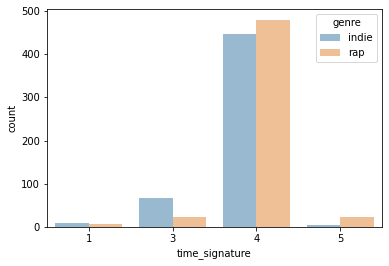

In [25]:
describe_1d(df,'time_signature','genre',discrete=True)
count_1d(df,'time_signature','genre')

Most tracks are 4/4 on both genres, but indie has more 3/4 songs and rap has more 5/4 songs.

#### 3.1.13 Valence

> - **valence (float)**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). >= 0<= 1

Rap songs tend to be more aggressive and feel fast, while indie songs tend to be calm and feel more melancholic.

,count,mean,std,min,25%,50%,75%,max
indie,528.0,0.428907,0.225966,0.0249,0.25775,0.403,0.58175,0.971
rap,530.0,0.594222,0.217626,0.0393,0.43025,0.615,0.75775,0.980


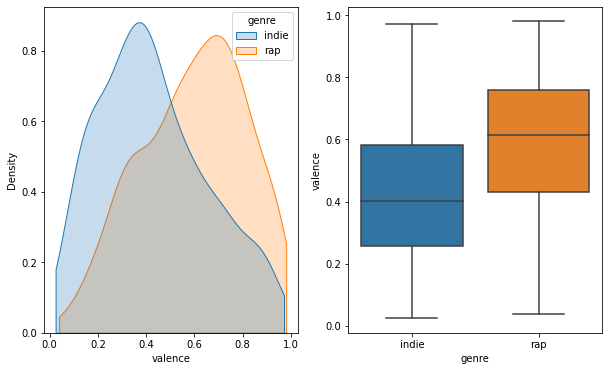

In [44]:
describe_1d(df,'valence','genre')
kde_1d(df,'valence','genre')

Both distributions have similar standard deviations, but rap has a considerably larger average valence than indie (0.59 vs. 0.43).

### 3.2 Multivariate analysis

Checking the correlation between the features is a good way to check how they interact with each other. This measure is good to determine if there are features highly correlated with the target, which have great potential to help with the classification, and to check if there are features that are highly intercorrelated, which makes them to offer the same information about the data, making it possible to drop some of them to reduce the computational cost of training the classifier without loosing much accuracy. 

In [45]:
feature_names = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature']
target_name = ['genre']

<AxesSubplot:>

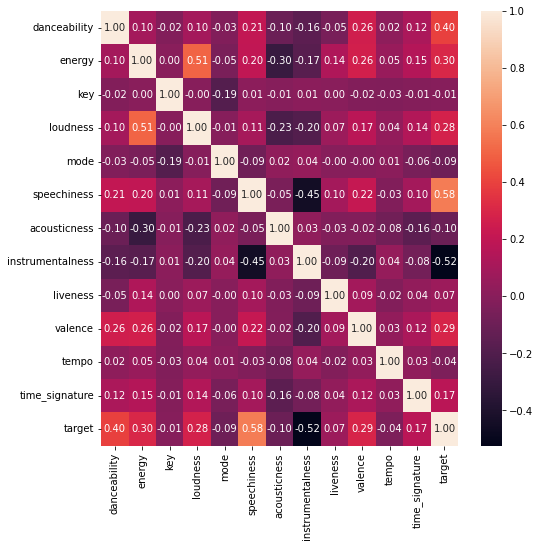

In [46]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(df[feature_names+['target']].corr(method='kendall'),annot=True,fmt=".2f")

As expected, speechiness is highly correlated with the genre (0.58). Danceability, Energy, Loudness and Valence also have a high correlation with the genre. 

Among the features, there's a strong inverse correlation between Instrumentallness and Speechiness, Acousticness and Energy and Acousticness and Loudness, what is expected, as we saw earlier in the description of the features. Loudness also has a high correlation with Energy.

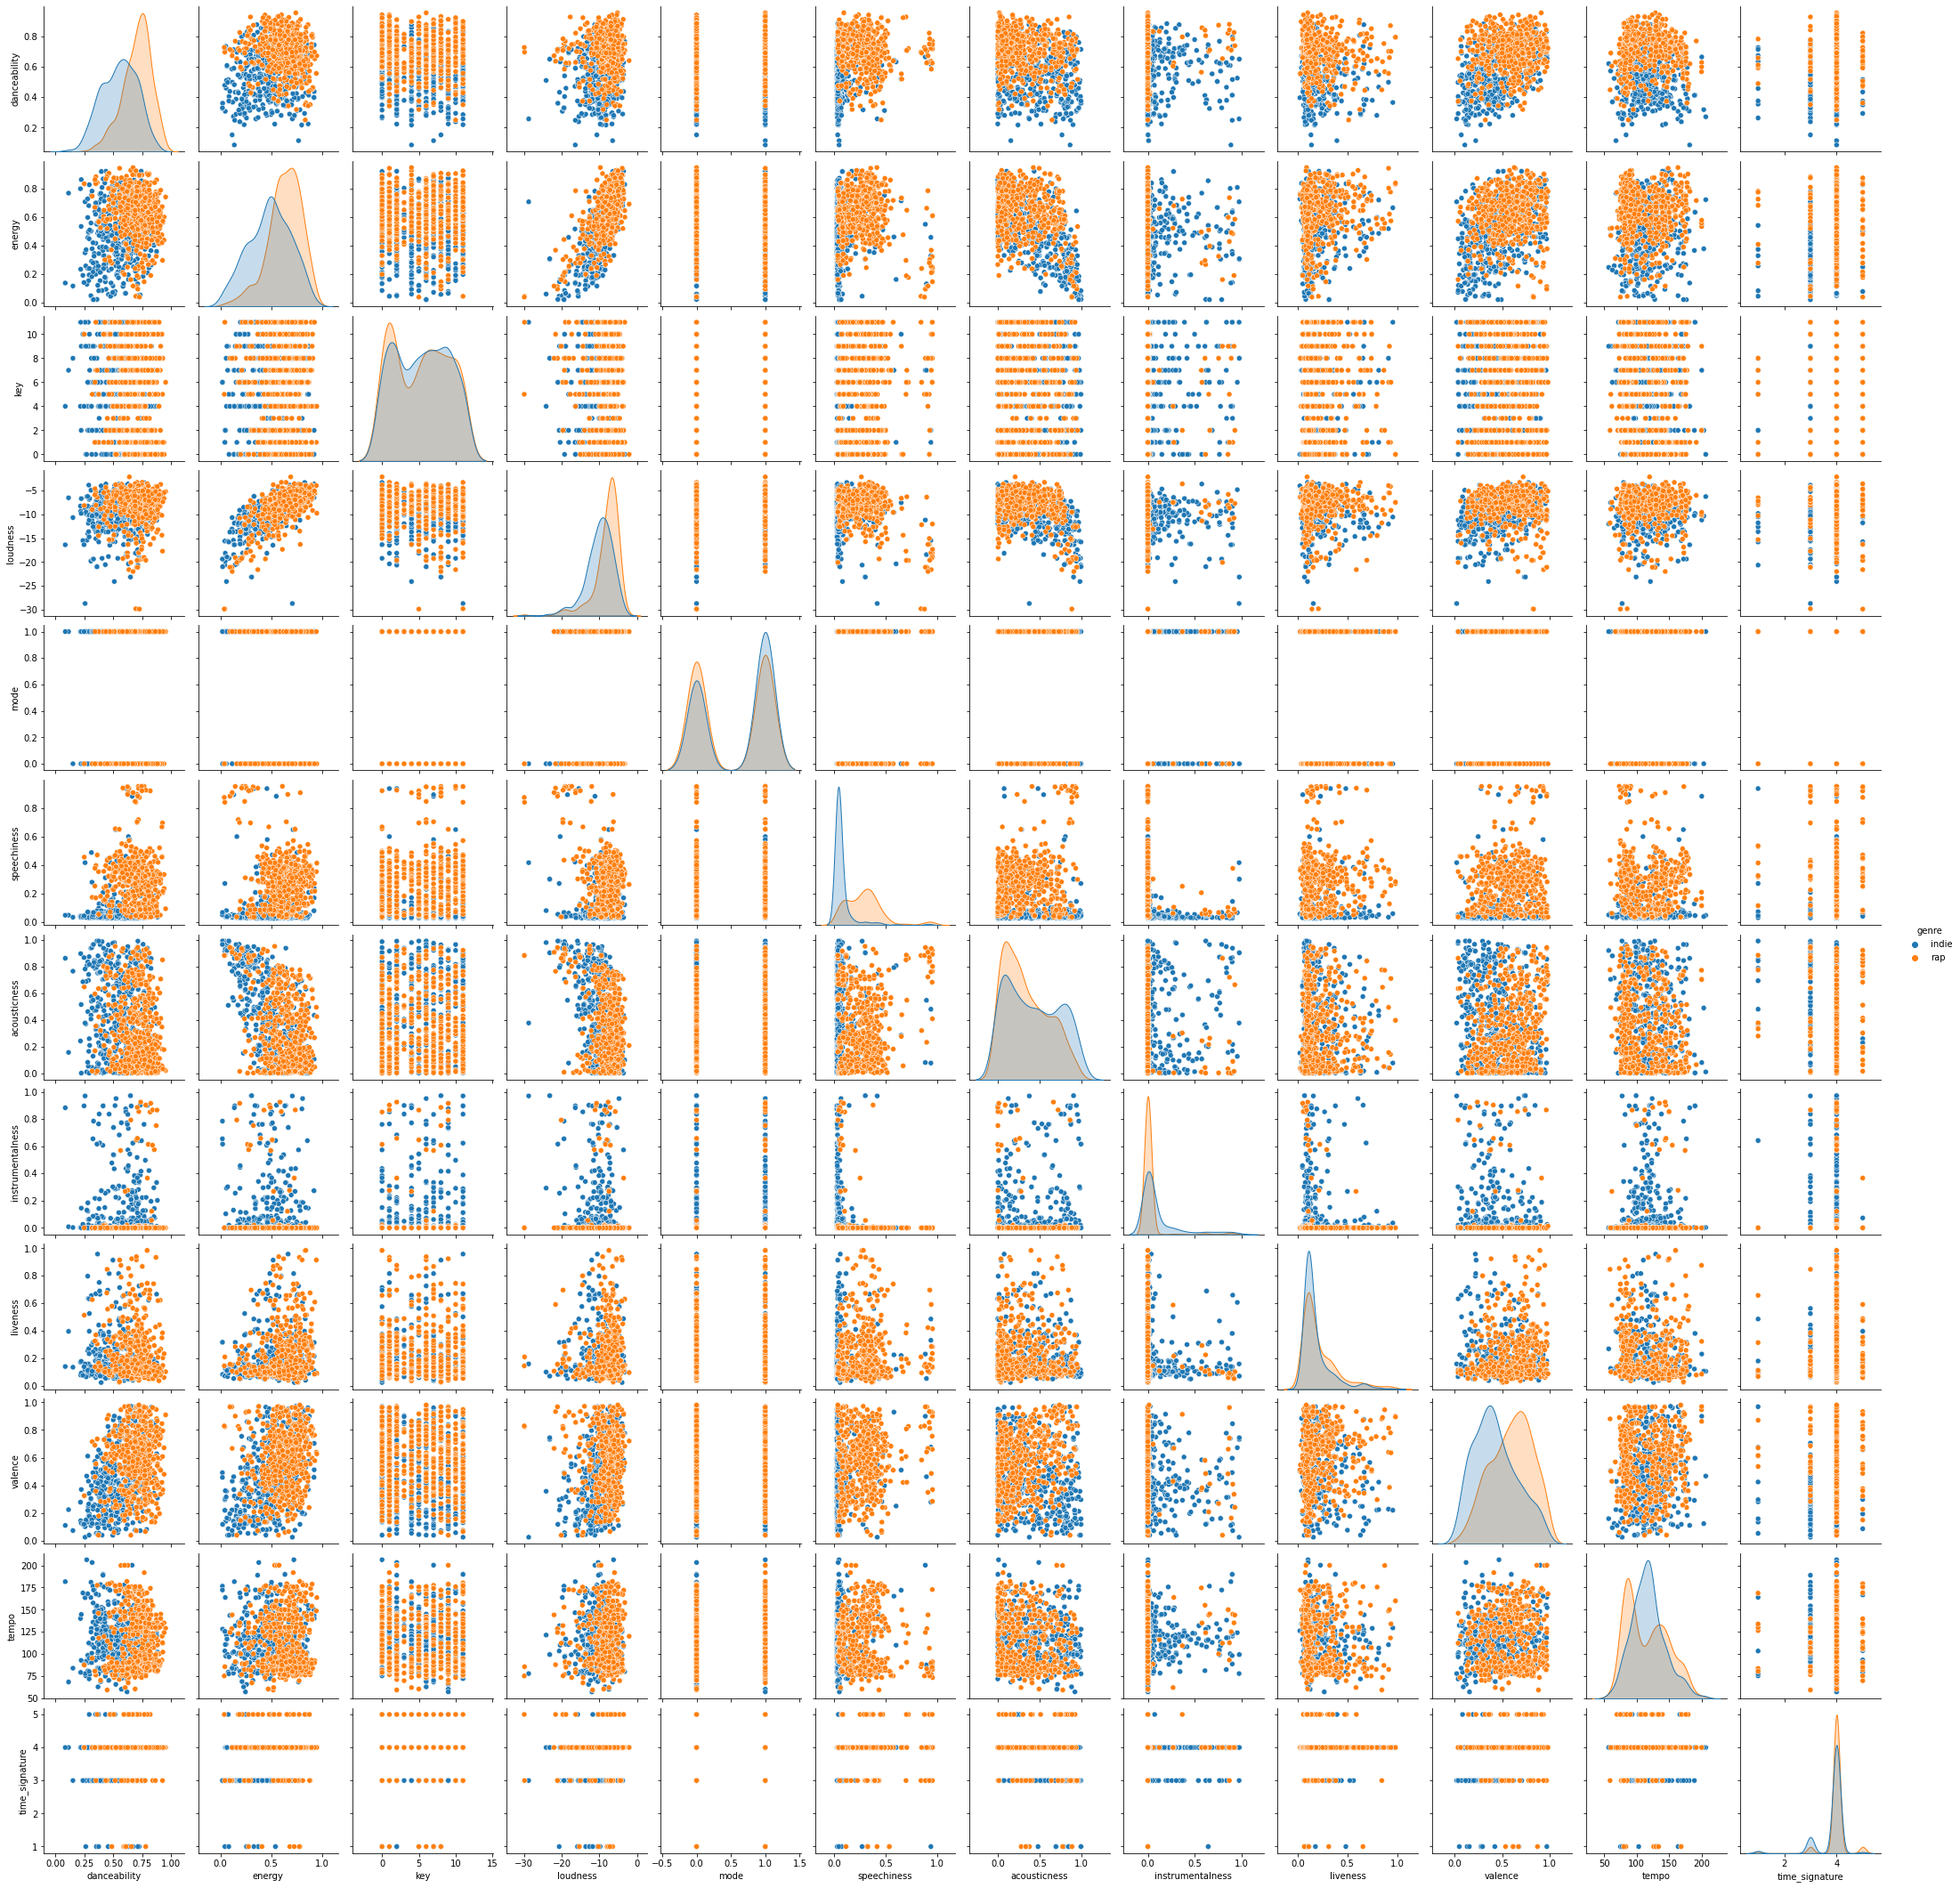

In [47]:
sns.pairplot(data=df[feature_names+['genre']],hue='genre')

As seen in the univariate analysis of speechiness, it is a feature that makes it possible to separate the dataset between the genres with a good accuracy. The pair plot of Danceability and Speechiness shows a good separation from the genres in the dataset, what is also seen in Energy and Valence, and Energy and Loudness plots.

## 4. Classification

We will train some classifiers from the data extracted earlier, spliting it into train and test data to make it possible to get a good measure of the accuracy from the trained models. In addition to model selection, we are going to select the features to use in the classification in order to optimize the complexity vs. accuracy relationship.

In [30]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

### 4.1 Feature Selection

Selecting the features that bring the most information to the model, without having repeated information, is one way to ensure good accuracy without making the model more complex than necessary.

A good way to select the features is based on the Kendall's correlation. We are going to choose the feature that have an absolute correlation with the target higher than 0.25. After this, we are going to remove the features that have an absolute correlation between them higher than 0.3. In that way, we are going to select the following features:

- Danceability
- Energy
- Speechiness
- Valence

We will use all features to train the classifier in order to compare the performance.

In [31]:
selected_feature_names = ['danceability','energy','speechiness','valence']

### 4.2 Model Selection

To make a fair comparison of the different classifier models possible, we will use GridSearchCV function to tune the hyperparameters of the models. Hyperparameters are parameters from the model that are not changed during training, they should be specified at the beggining of the training and they control how the model will fit the data.

We will select from 5 models of classifiers:

#### 4.2.1 K Nearest Neighbors (KNN)

KNN is one of the simplest classifiers available. When predicting the class of a data point, it will find the k nearest neighbors of the data point and check their classes, assigning it the most common class found. The principal hyperparameter from knn is "k", the number of nearest neighbors that will be taken into account in the classification.

In [32]:
feature_options = [['All features']+feature_names,['Selected features']+selected_feature_names]
for features in feature_options:
    X = df[features[1:]]
    y = df['target']
    scaler = RobustScaler()
    X = scaler.fit_transform(X)
    knn = KNeighborsClassifier()
    param_grid = {'n_neighbors': [1,5,10,30,50,100]}
    clf = GridSearchCV(knn,param_grid,cv=10)
    clf.fit(X,y)
    print(features[0])
    params = clf.cv_results_['params']
    score = list(clf.cv_results_['mean_test_score'])
    index = score.index(max(score))
    print(params[index],score[index])
    print('\n')

All features
{'n_neighbors': 30} 0.8648876909254268


Selected features
{'n_neighbors': 30} 0.8562533692722372




For both features lists, using 30 neighbors gave the best result, with an average score of 86.5% for all the 10 folds of cross validation for the model trained with all features and 85.6% for the model trained with the selected features. With one-third the number of features, the model trained with the 4 selected features performed quite well.

#### 4.2.2 Support Vector Machine Classifier (SVC)

SVC algorithm is based on finding the hyperplane that best separate the dataset. While hyperplanes are linear, we can use "kernels" to bring nonlinearity to the model, which will make it possible to separate the dataset with boundaries that are not always linear. The principal hyperparameters of SVC are the kernel type and "C", a regularization parameter.

In [48]:
feature_options = [['All features']+feature_names,['Selected features']+selected_feature_names]
for features in feature_options:
    X = df[features[1:]]
    y = df['target']
    scaler = RobustScaler()
    X = scaler.fit_transform(X)
    svc = SVC()
    param_grid = {'kernel': ['linear','rbf'], 'C': [0.1,0.5,1,2,5,10]}
    clf = GridSearchCV(svc,param_grid,cv=10)
    clf.fit(X,y)
    print(features[0])
    params = clf.cv_results_['params']
    score = list(clf.cv_results_['mean_test_score'])
    index = score.index(max(score))
    print(params[index],score[index])
    print('\n')

All features
{'C': 5, 'kernel': 'rbf'} 0.8621024258760108


Selected features
{'C': 1, 'kernel': 'rbf'} 0.8581581311769991




The rbf kernel is the best option. It is the default kernel option for support vector machines, being based on an exponential approach of the euclidean distance, making it possible to create complex boundaries and achieve high accuracy levels. For the model trained with all features, a "C" parameter of 5 provided a classifier with 86.2% of accuracy, while for the model trained with the selected features got 85.8% accuracy with a "C" parameter of 1.

#### 4.2.3 Random Forest Classifier (RFC)

RFC is an algorithm based on creating random subsamples from the dataset and training decision trees on them. The trained trees results will be averaged, creating a powerful classifier based on decision trees that doesn't tends to overfit as mch as the trees themselves. The main hyperparameters is "n_estimators", the number of decision trees trained.

In [34]:
feature_options = [['All features']+feature_names,['Selected features']+selected_feature_names]
for features in feature_options:
    X = df[features[1:]]
    y = df['target']
    scaler = RobustScaler()
    X = scaler.fit_transform(X)
    rfc = RandomForestClassifier()
    param_grid = {'n_estimators': [20,50,100,200,500]}
    clf = GridSearchCV(rfc,param_grid,cv=10)
    clf.fit(X,y)
    print(features[0])
    params = clf.cv_results_['params']
    score = list(clf.cv_results_['mean_test_score'])
    index = score.index(max(score))
    print(params[index],score[index])
    print('\n')

All features
{'n_estimators': 50} 0.880880503144654


Selected features
{'n_estimators': 200} 0.8553279424977538




As expected, the Random Forest algorithm provided models with higher accuracy. Decision tree is an easy to interpret algorithm that has a high power of capturing useful information from the data, but also has a high tendency to overfitting. High-depth decision trees can fit the training data very well, but will have low power of generalization, in a way that they can't perform well in prediction. Using the bagging concept, i.e. subsampling the dataset randomly to train a large amount of low complexity classifiers, we can create a model that can learn a lot from the training data without loosing too much capacity of generalization.

For the model trained with all features, using 200 estimators made the model reach an accuracy score of 88.1%, while the model trained with the selected features achieved an accuracy of 85.6% with 100 estimators. In this case, the difference between using the selected features and all features was greater than before. One possible explanation is that Random Forest can extract more information from the data and even low correlation features can be important when combined with others, which is an advantage of this algorithm.

### 4.3 Performance Evaluation

We will calculate some metrics from the model to evaluate its performance. Due to the relatively small size of the dataset, we are going to calculate 10 times, for different train-test splits to get average values from the metrics.


In [ ]:
X = df[feature_names]
y = df['target']
acc = []
auc = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    rfc = RandomForestClassifier(n_estimators = 200)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    acc.append(accuracy_score(y_test,y_pred))
    y_score = clf.predict_proba(X_test)[:, 1]
    auc.append(roc_auc_score(y_test,y_score))

In [42]:
print('Average accuracy: {:.4f}'.format(sum(acc)/len(acc)))
print('Average ROC AUC score: {:.4f}'.format(sum(auc)/len(auc)))

Average accuracy: 0.9189
Average ROC AUC score: 0.9652


The achieved accuracy and AUC scores for train test split evaluation are good, indicating that there are no overfitring and other effects that could affect the performance of the deployed model.